# Exoplanet Classification (Numeric-Only Features)

Models: Gradient Descent (SGD), RandomForest, HistGradientBoosting, and MLP Neural Network.

Features used:
- `orbital_period`, `transit_depth`, `radius_ratio`, `stellar_radius`, `stellar_mass`, `signal_to_noise`, `duration_hours`

Target: `is_planet` inferred from disposition (Confirmed=1, False Positive=0; candidates dropped).


In [1]:
# %% [setup] Imports and config
import os
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
np.random.seed(SEED)

DATA_DIR = r"C:\\progremming\\task zagzig\\Nasa hachthaon\\data\\raw"
KOI_PATH = os.path.join(DATA_DIR, 'koi.csv')
NUMERIC_FEATURES = [
    'orbital_period','transit_depth','radius_ratio','stellar_radius','stellar_mass','signal_to_noise','duration_hours'
]
LABEL_COLUMN = 'is_planet'


c:\Users\hp\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# %% [data] Load KOI, extract numeric-only features, save CSV
raw = pd.read_csv(KOI_PATH, low_memory=False)

# Infer labels from disposition
disp = raw.get('koi_disposition')
label = None
if disp is not None:
    s = disp.astype(str).str.strip().str.upper()
    pos = {'CONFIRMED', 'CONFIRMED PLANET', 'PLANET CONFIRMED', 'CONF'}
    neg = {'FALSE POSITIVE', 'FP', 'FALSE-POSITIVE', 'REJECTED', 'NOT CONFIRMED'}
    label = s.map(lambda x: 1 if x in pos else (0 if x in neg else np.nan))

# Build numeric-only frame from KOI columns
out = pd.DataFrame()
out['orbital_period'] = pd.to_numeric(raw.get('koi_period'), errors='coerce')
# Transit depth (convert ppm to fraction if needed)
depth = pd.to_numeric(raw.get('koi_depth'), errors='coerce')
if depth is not None:
    depth_guess = depth.copy()
    ppm_like = depth_guess.abs() > 1e-2
    depth_guess.loc[ppm_like] = depth_guess.loc[ppm_like] / 1e6
    out['transit_depth'] = depth_guess
else:
    out['transit_depth'] = np.nan

out['radius_ratio'] = pd.to_numeric(raw.get('koi_ror'), errors='coerce')
out['stellar_radius'] = pd.to_numeric(raw.get('st_rad'), errors='coerce')
out['stellar_mass'] = pd.to_numeric(raw.get('st_mass'), errors='coerce')
snr = pd.to_numeric(raw.get('koi_model_snr'), errors='coerce')
if snr.isna().all():
    snr = pd.to_numeric(raw.get('koi_snr'), errors='coerce')
out['signal_to_noise'] = snr
out['duration_hours'] = pd.to_numeric(raw.get('koi_duration'), errors='coerce')

# Derive missing ror/depth where possible
need_ror = out['radius_ratio'].isna() & out['transit_depth'].notna()
out.loc[need_ror, 'radius_ratio'] = np.sqrt(np.clip(out.loc[need_ror, 'transit_depth'], 0.0, None))
need_depth = out['transit_depth'].isna() & out['radius_ratio'].notna()
out.loc[need_depth, 'transit_depth'] = (out.loc[need_depth, 'radius_ratio'] ** 2)

# Attach label (drop candidates)
out[LABEL_COLUMN] = label
sup = out[out[LABEL_COLUMN].isin([0,1])].copy()

# Save numeric-only KOI
num_path = os.path.join(DATA_DIR, 'koi_numeric_only.csv')
sup[NUMERIC_FEATURES + [LABEL_COLUMN]].to_csv(num_path, index=False)
print(f"Saved numeric-only KOI to: {num_path}")

sup.head(5)


Saved numeric-only KOI to: C:\\progremming\\task zagzig\\Nasa hachthaon\\data\\raw\koi_numeric_only.csv


,orbital_period,transit_depth,radius_ratio,stellar_radius,stellar_mass,signal_to_noise,duration_hours,is_planet
0,19.899140,0.010829,0.154046,NaN,NaN,76.3,1.78220,0.0
1,1.736952,0.008079,0.387394,NaN,NaN,505.6,2.40641,0.0
2,2.525592,0.000603,0.024064,NaN,NaN,40.9,1.65450,1.0
3,11.094321,0.001517,0.036779,NaN,NaN,66.5,4.59450,1.0
4,4.134435,0.000686,0.026133,NaN,NaN,40.2,3.14020,1.0


In [3]:
# %% [split] Train/Val/Test split and preprocessing
X = sup[NUMERIC_FEATURES].values
y = sup[LABEL_COLUMN].values.astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

imp = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imp = imp.fit_transform(X_train)
X_val_imp = imp.transform(X_val)
X_test_imp = imp.transform(X_test)

X_train_std = scaler.fit_transform(X_train_imp)
X_val_std = scaler.transform(X_val_imp)
X_test_std = scaler.transform(X_test_imp)

print('Shapes:', X_train_std.shape, X_val_std.shape, X_test_std.shape)


Shapes: (4685, 5) (1004, 5) (1005, 5)


c:\Users\hp\anaconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [3 4]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [3 4]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [3 4]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [4]:
# %% [sgd] Gradient Descent (SGD) baseline
sgd = SGDClassifier(loss='log_loss', alpha=1e-4, random_state=SEED, max_iter=1000, tol=1e-3)
sgd.fit(X_train_std, y_train)

val_pred = (sgd.predict_proba(X_val_std)[:,1] >= 0.5).astype(int)
val_metrics = {
    'accuracy': accuracy_score(y_val, val_pred),
    'precision': precision_score(y_val, val_pred, zero_division=0),
    'recall': recall_score(y_val, val_pred, zero_division=0),
    'f1': f1_score(y_val, val_pred, zero_division=0),
}
print('SGD val:', val_metrics)

test_pred = (sgd.predict_proba(X_test_std)[:,1] >= 0.5).astype(int)
sgd_metrics = {
    'accuracy': accuracy_score(y_test, test_pred),
    'precision': precision_score(y_test, test_pred, zero_division=0),
    'recall': recall_score(y_test, test_pred, zero_division=0),
    'f1': f1_score(y_test, test_pred, zero_division=0),
}
print('SGD test:', sgd_metrics)


SGD val: {'accuracy': 0.7280876494023905, 'precision': 0.6069182389937107, 'recall': 0.9437652811735942, 'f1': 0.738755980861244}
SGD test: {'accuracy': 0.7213930348258707, 'precision': 0.6028481012658228, 'recall': 0.9292682926829269, 'f1': 0.7312859884836852}


In [5]:
# %% [rf] RandomForest
rf = RandomForestClassifier(n_estimators=400, max_depth=None, n_jobs=-1, random_state=SEED, class_weight='balanced')
rf.fit(X_train_imp, y_train)

rf_pred = rf.predict(X_test_imp)
rf_metrics = {
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_score(y_test, rf_pred, zero_division=0),
    'recall': recall_score(y_test, rf_pred, zero_division=0),
    'f1': f1_score(y_test, rf_pred, zero_division=0),
}
print('RF test:', rf_metrics)


RF test: {'accuracy': 0.909452736318408, 'precision': 0.8752941176470588, 'recall': 0.9073170731707317, 'f1': 0.8910179640718563}


In [6]:
# %% [gbm] HistGradientBoosting
hgb = HistGradientBoostingClassifier(learning_rate=0.05, max_iter=600, max_bins=255, l2_regularization=1e-4,
                                     early_stopping=True, validation_fraction=0.2, random_state=SEED)
hgb.fit(X_train_imp, y_train)

gbm_proba = hgb.predict_proba(X_test_imp)[:,1]
gbm_pred = (gbm_proba >= 0.5).astype(int)
gbm_metrics = {
    'accuracy': accuracy_score(y_test, gbm_pred),
    'precision': precision_score(y_test, gbm_pred, zero_division=0),
    'recall': recall_score(y_test, gbm_pred, zero_division=0),
    'f1': f1_score(y_test, gbm_pred, zero_division=0),
}
print('GBM test:', gbm_metrics)


c:\Users\hp\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\hp\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


GBM test: {'accuracy': 0.9064676616915422, 'precision': 0.860730593607306, 'recall': 0.9195121951219513, 'f1': 0.8891509433962265}


In [7]:
# %% [mlp] MLP Neural Network (on standardized features)
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', alpha=1e-4,
                    batch_size=256, learning_rate_init=1e-3, max_iter=100, random_state=SEED, early_stopping=True,
                    n_iter_no_change=10, validation_fraction=0.2)
mlp.fit(X_train_std, y_train)

mlp_pred = mlp.predict(X_test_std)
mlp_metrics = {
    'accuracy': accuracy_score(y_test, mlp_pred),
    'precision': precision_score(y_test, mlp_pred, zero_division=0),
    'recall': recall_score(y_test, mlp_pred, zero_division=0),
    'f1': f1_score(y_test, mlp_pred, zero_division=0),
}
print('MLP test:', mlp_metrics)


MLP test: {'accuracy': 0.8746268656716418, 'precision': 0.8256880733944955, 'recall': 0.8780487804878049, 'f1': 0.851063829787234}


,model,accuracy,precision,recall,f1
0,RandomForest,0.909453,0.875294,0.907317,0.891018
1,HistGBM,0.906468,0.860731,0.919512,0.889151
2,MLP,0.874627,0.825688,0.878049,0.851064
3,SGD,0.721393,0.602848,0.929268,0.731286


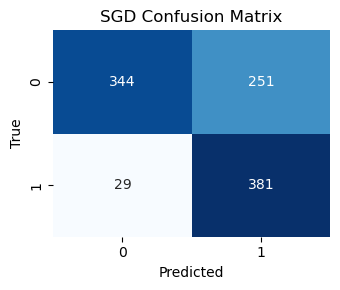

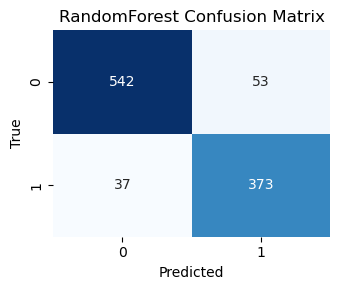

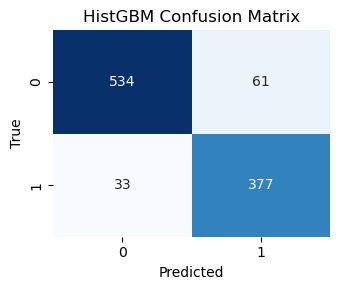

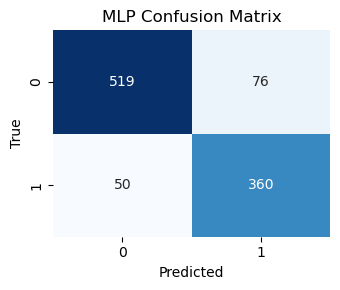

In [8]:
# %% [compare] Comparison table and confusion matrices
models = [
    ('SGD', sgd_metrics, (sgd, X_test_std)),
    ('RandomForest', rf_metrics, (rf, X_test_imp)),
    ('HistGBM', gbm_metrics, (hgb, X_test_imp)),
    ('MLP', mlp_metrics, (mlp, X_test_std)),
]

rows = []
for name, m, _ in models:
    rows.append({'model': name, **m})

cmp_df = pd.DataFrame(rows).sort_values('f1', ascending=False).reset_index(drop=True)
display(cmp_df)

# Confusion matrices
for name, _, (est, Xte) in models:
    if hasattr(est, 'predict_proba'):
        pred = (est.predict_proba(Xte)[:,1] >= 0.5).astype(int)
    else:
        pred = est.predict(Xte)
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(3.5,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout(); plt.show()


In [9]:
# %% [report] Save report
report = {
    'sgd': sgd_metrics,
    'random_forest': rf_metrics,
    'hist_gbm': gbm_metrics,
    'mlp': mlp_metrics,
}
out_path = os.path.join(DATA_DIR, 'numeric_only_models_report.json')
import json
with open(out_path, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2)
print(f"Saved report to: {out_path}")


Saved report to: C:\\progremming\\task zagzig\\Nasa hachthaon\\data\\raw\numeric_only_models_report.json


In [10]:
# %% [save_models] Persist trained models and preprocessors
import joblib

models_dir = os.path.join(DATA_DIR, 'models')
os.makedirs(models_dir, exist_ok=True)

artifacts = {
    'sgd_model.joblib': sgd,
    'rf_model.joblib': rf,
    'histgbm_model.joblib': hgb,
    'mlp_model.joblib': mlp,
    'imputer.joblib': imp,
    'scaler.joblib': scaler,
    'features.json': NUMERIC_FEATURES,
}

for name, obj in artifacts.items():
    path = os.path.join(models_dir, name)
    if name.endswith('.json'):
        import json
        with open(path, 'w', encoding='utf-8') as f:
            json.dump(obj, f, indent=2)
    else:
        joblib.dump(obj, path)
    print(f"Saved {name} -> {path}")


Saved sgd_model.joblib -> C:\\progremming\\task zagzig\\Nasa hachthaon\\data\\raw\models\sgd_model.joblib
Saved rf_model.joblib -> C:\\progremming\\task zagzig\\Nasa hachthaon\\data\\raw\models\rf_model.joblib
Saved histgbm_model.joblib -> C:\\progremming\\task zagzig\\Nasa hachthaon\\data\\raw\models\histgbm_model.joblib
Saved mlp_model.joblib -> C:\\progremming\\task zagzig\\Nasa hachthaon\\data\\raw\models\mlp_model.joblib
Saved imputer.joblib -> C:\\progremming\\task zagzig\\Nasa hachthaon\\data\\raw\models\imputer.joblib
Saved scaler.joblib -> C:\\progremming\\task zagzig\\Nasa hachthaon\\data\\raw\models\scaler.joblib
Saved features.json -> C:\\progremming\\task zagzig\\Nasa hachthaon\\data\\raw\models\features.json


In [11]:
# %% [save_best] Select and save the best model by F1
import json, joblib

candidates = {
    'SGD': {'metrics': sgd_metrics, 'model': sgd, 'preproc': 'std'},
    'RandomForest': {'metrics': rf_metrics, 'model': rf, 'preproc': 'imp'},
    'HistGBM': {'metrics': gbm_metrics, 'model': hgb, 'preproc': 'imp'},
    'MLP': {'metrics': mlp_metrics, 'model': mlp, 'preproc': 'std'},
}

best_name = None
best = None
best_f1 = -1.0
for name, info in candidates.items():
    f1v = float(info['metrics'].get('f1', -1))
    if f1v > best_f1:
        best_f1 = f1v
        best_name = name
        best = info

best_dir = os.path.join(DATA_DIR, 'models')
os.makedirs(best_dir, exist_ok=True)

# Save best model
best_model_path = os.path.join(best_dir, 'best_model.joblib')
joblib.dump(best['model'], best_model_path)

# Save required preprocessors for reuse
best_imputer_path = None
best_scaler_path = None
if best['preproc'] == 'std':
    best_imputer_path = os.path.join(best_dir, 'best_imputer.joblib')
    best_scaler_path = os.path.join(best_dir, 'best_scaler.joblib')
    joblib.dump(imp, best_imputer_path)
    joblib.dump(scaler, best_scaler_path)
elif best['preproc'] == 'imp':
    best_imputer_path = os.path.join(best_dir, 'best_imputer.joblib')
    joblib.dump(imp, best_imputer_path)

# Metadata
best_meta = {
    'best_model_name': best_name,
    'best_f1': best_f1,
    'metrics': best['metrics'],
    'preprocessing': best['preproc'],
    'artifacts': {
        'model': os.path.basename(best_model_path),
        'imputer': os.path.basename(best_imputer_path) if best_imputer_path else None,
        'scaler': os.path.basename(best_scaler_path) if best_scaler_path else None,
        'features': NUMERIC_FEATURES,
    }
}
with open(os.path.join(best_dir, 'best_model_meta.json'), 'w', encoding='utf-8') as f:
    json.dump(best_meta, f, indent=2)

print(f"Saved best model ({best_name}) with F1={best_f1:.4f}")
print("Artifacts in:", best_dir)


Saved best model (RandomForest) with F1=0.8910
Artifacts in: C:\\progremming\\task zagzig\\Nasa hachthaon\\data\\raw\models


In [12]:
# %% [k2_toi_helpers] Loaders for K2 (k2.csv) and TESS (toi.csv) using numeric-only features
K2_PATH = os.path.join(DATA_DIR, 'k2.csv')
TOI_PATH = os.path.join(DATA_DIR, 'toi.csv')

# Infer label from common disposition-like fields
POS = {'CONFIRMED', 'CONFIRMED PLANET', 'PLANET CONFIRMED', 'CONF'}
NEG = {'FALSE POSITIVE', 'FP', 'FALSE-POSITIVE', 'REJECTED', 'NOT CONFIRMED'}


def infer_label_from(df: pd.DataFrame, cols: list) -> pd.Series:
    for c in cols:
        if c in df.columns:
            s = df[c].astype(str).str.strip().str.upper()
            return s.map(lambda x: 1 if x in POS else (0 if x in NEG else np.nan))
    return pd.Series(np.nan, index=df.index)


def build_numeric(df: pd.DataFrame, mappings: Dict[str, list]) -> pd.DataFrame:
    out = pd.DataFrame()
    # numeric mappings (first present wins)
    def first_num(df, cand):
        for c in cand:
            if c in df.columns:
                return pd.to_numeric(df[c], errors='coerce')
        return pd.Series(np.nan, index=df.index)

    out['orbital_period'] = first_num(df, mappings.get('orbital_period', []))
    depth = first_num(df, mappings.get('transit_depth', []))
    depth_guess = depth.copy()
    ppm_like = depth_guess.abs() > 1e-2
    depth_guess.loc[ppm_like] = depth_guess.loc[ppm_like] / 1e6
    out['transit_depth'] = depth_guess
    out['radius_ratio'] = first_num(df, mappings.get('radius_ratio', []))
    out['stellar_radius'] = first_num(df, mappings.get('stellar_radius', []))
    out['stellar_mass'] = first_num(df, mappings.get('stellar_mass', []))
    snr = first_num(df, mappings.get('signal_to_noise', []))
    out['signal_to_noise'] = snr
    out['duration_hours'] = first_num(df, mappings.get('duration_hours', []))

    # Fill radius_ratio from depth if missing
    need_ror = out['radius_ratio'].isna() & out['transit_depth'].notna()
    out.loc[need_ror, 'radius_ratio'] = np.sqrt(np.clip(out.loc[need_ror, 'transit_depth'], 0.0, None))
    need_depth = out['transit_depth'].isna() & out['radius_ratio'].notna()
    out.loc[need_depth, 'transit_depth'] = (out.loc[need_depth, 'radius_ratio'] ** 2)
    return out

# Column alias mappings for K2/TOI (adjust as needed)
K2_MAP = {
    'orbital_period': ['koi_period', 'orbital_period', 'per'],
    'transit_depth': ['koi_depth', 'depth', 'Transit Depth (ppm)'],
    'radius_ratio': ['koi_ror', 'rp_rs'],
    'stellar_radius': ['st_rad', 'stellar_radius'],
    'stellar_mass': ['st_mass', 'stellar_mass'],
    'signal_to_noise': ['koi_model_snr', 'koi_snr', 'SNR'],
    'duration_hours': ['koi_duration', 'duration_hours'],
}
TOI_MAP = {
    'orbital_period': ['orbital_period', 'pl_orbper'],
    'transit_depth': ['transit_depth', 'depth', 'Transit Depth (ppm)'],
    'radius_ratio': ['radius_ratio', 'rp_rs'],
    'stellar_radius': ['stellar_radius', 'st_rad'],
    'stellar_mass': ['stellar_mass', 'st_mass'],
    'signal_to_noise': ['signal_to_noise', 'SNR'],
    'duration_hours': ['duration_hours', 'Transit Duration (hours)'],
}


def load_k2_numeric():
    df = pd.read_csv(K2_PATH, low_memory=False)
    y = infer_label_from(df, ['k2_disposition', 'koi_disposition', 'Disposition', 'disposition'])
    X = build_numeric(df, K2_MAP)
    X[LABEL_COLUMN] = y
    X = X[X[LABEL_COLUMN].isin([0,1])].copy()
    return X


def load_toi_numeric():
    df = pd.read_csv(TOI_PATH, low_memory=False)
    y = infer_label_from(df, ['TFOPWG Disposition', 'Disposition', 'disposition'])
    X = build_numeric(df, TOI_MAP)
    X[LABEL_COLUMN] = y
    X = X[X[LABEL_COLUMN].isin([0,1])].copy()
    return X


In [13]:
# %% [k2_toi_train] Train models for K2 and TOI (TESS)

def train_eval_numeric(df: pd.DataFrame, mission_name: str):
    X = df[NUMERIC_FEATURES].values
    y = df[LABEL_COLUMN].values.astype(int)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

    imp_ = SimpleImputer(strategy='median')
    sc_ = StandardScaler()

    X_train_imp_ = imp_.fit_transform(X_train)
    X_val_imp_ = imp_.transform(X_val)
    X_test_imp_ = imp_.transform(X_test)

    X_train_std_ = sc_.fit_transform(X_train_imp_)
    X_val_std_ = sc_.transform(X_val_imp_)
    X_test_std_ = sc_.transform(X_test_imp_)

    # SGD
    sgd_ = SGDClassifier(loss='log_loss', alpha=1e-4, random_state=SEED, max_iter=1000, tol=1e-3)
    sgd_.fit(X_train_std_, y_train)
    sgd_pred = (sgd_.predict_proba(X_test_std_)[:,1] >= 0.5).astype(int)
    sgd_m = {
        'accuracy': accuracy_score(y_test, sgd_pred),
        'precision': precision_score(y_test, sgd_pred, zero_division=0),
        'recall': recall_score(y_test, sgd_pred, zero_division=0),
        'f1': f1_score(y_test, sgd_pred, zero_division=0),
    }

    # RF
    rf_ = RandomForestClassifier(n_estimators=400, max_depth=None, n_jobs=-1, random_state=SEED, class_weight='balanced')
    rf_.fit(X_train_imp_, y_train)
    rf_pred = rf_.predict(X_test_imp_)
    rf_m = {
        'accuracy': accuracy_score(y_test, rf_pred),
        'precision': precision_score(y_test, rf_pred, zero_division=0),
        'recall': recall_score(y_test, rf_pred, zero_division=0),
        'f1': f1_score(y_test, rf_pred, zero_division=0),
    }

    # GBM
    hgb_ = HistGradientBoostingClassifier(learning_rate=0.05, max_iter=600, max_bins=255, l2_regularization=1e-4,
                                          early_stopping=True, validation_fraction=0.2, random_state=SEED)
    hgb_.fit(X_train_imp_, y_train)
    gbm_pred = (hgb_.predict_proba(X_test_imp_)[:,1] >= 0.5).astype(int)
    gbm_m = {
        'accuracy': accuracy_score(y_test, gbm_pred),
        'precision': precision_score(y_test, gbm_pred, zero_division=0),
        'recall': recall_score(y_test, gbm_pred, zero_division=0),
        'f1': f1_score(y_test, gbm_pred, zero_division=0),
    }

    # MLP
    mlp_ = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', alpha=1e-4,
                         batch_size=256, learning_rate_init=1e-3, max_iter=100, random_state=SEED, early_stopping=True,
                         n_iter_no_change=10, validation_fraction=0.2)
    mlp_.fit(X_train_std_, y_train)
    mlp_pred = mlp_.predict(X_test_std_)
    mlp_m = {
        'accuracy': accuracy_score(y_test, mlp_pred),
        'precision': precision_score(y_test, mlp_pred, zero_division=0),
        'recall': recall_score(y_test, mlp_pred, zero_division=0),
        'f1': f1_score(y_test, mlp_pred, zero_division=0),
    }

    cmp = pd.DataFrame([
        {'model': 'SGD', **sgd_m},
        {'model': 'RandomForest', **rf_m},
        {'model': 'HistGBM', **gbm_m},
        {'model': 'MLP', **mlp_m},
    ]).sort_values('f1', ascending=False).reset_index(drop=True)

    return {
        'cmp': cmp,
        'artifacts': {'sgd': sgd_, 'rf': rf_, 'hgb': hgb_, 'mlp': mlp_, 'imp': imp_, 'scaler': sc_},
    }

# Run for K2 and TOI (skip if insufficient labels)
try:
    k2_df = load_k2_numeric()
    print('K2 labeled samples:', len(k2_df))
    k2_res = train_eval_numeric(k2_df, 'K2') if len(k2_df) >= 50 else None
    if k2_res:
        display(k2_res['cmp'])
except Exception as e:
    print('K2 error:', e)

try:
    toi_df = load_toi_numeric()
    print('TOI labeled samples:', len(toi_df))
    toi_res = train_eval_numeric(toi_df, 'TESS') if len(toi_df) >= 50 else None
    if toi_res:
        display(toi_res['cmp'])
except Exception as e:
    print('TOI error:', e)


K2 labeled samples: 2608


c:\Users\hp\anaconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [0 1 2 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [0 1 2 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [0 1 2 5 6]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


,model,accuracy,precision,recall,f1
0,HistGBM,0.905612,0.912467,0.988506,0.948966
1,MLP,0.887755,0.887755,1.000000,0.940541
2,SGD,0.887755,0.889744,0.997126,0.940379
3,RandomForest,0.875000,0.923513,0.936782,0.930100


TOI labeled samples: 0


In [14]:
# %% [k2_toi_save] Save per-mission reports and best models (if available)
import json, joblib

for name, res in [('K2', locals().get('k2_res')), ('TESS', locals().get('toi_res'))]:
    if not res:
        continue
    cmp = res['cmp']
    best_row = cmp.iloc[0]
    best_name = best_row['model']
    best_f1 = float(best_row['f1'])
    arts = res['artifacts']

    best_dir = os.path.join(DATA_DIR, f'models_{name.lower()}')
    os.makedirs(best_dir, exist_ok=True)

    # Save models
    joblib.dump(arts['sgd'], os.path.join(best_dir, 'sgd_model.joblib'))
    joblib.dump(arts['rf'], os.path.join(best_dir, 'rf_model.joblib'))
    joblib.dump(arts['hgb'], os.path.join(best_dir, 'histgbm_model.joblib'))
    joblib.dump(arts['mlp'], os.path.join(best_dir, 'mlp_model.joblib'))
    joblib.dump(arts['imp'], os.path.join(best_dir, 'imputer.joblib'))
    joblib.dump(arts['scaler'], os.path.join(best_dir, 'scaler.joblib'))
    with open(os.path.join(best_dir, 'features.json'), 'w', encoding='utf-8') as f:
        json.dump(NUMERIC_FEATURES, f, indent=2)

    # Save best
    best_model = arts['sgd'] if best_name == 'SGD' else arts['rf'] if best_name == 'RandomForest' else arts['hgb'] if best_name == 'HistGBM' else arts['mlp']
    joblib.dump(best_model, os.path.join(best_dir, 'best_model.joblib'))
    meta = {
        'best_model_name': best_name,
        'best_f1': best_f1,
        'comparison': cmp.to_dict(orient='records'),
        'features': NUMERIC_FEATURES,
    }
    with open(os.path.join(best_dir, 'best_model_meta.json'), 'w', encoding='utf-8') as f:
        json.dump(meta, f, indent=2)

    print(f"Saved {name} models to {best_dir}; best={best_name} f1={best_f1:.4f}")


Saved K2 models to C:\\progremming\\task zagzig\\Nasa hachthaon\\data\\raw\models_k2; best=HistGBM f1=0.9490
